# Isolating Failure-Inducing Changes

"Yesterday, my program worked. Today, it does not. Why?" In debugging, as elsewhere in software development, code keeps on changing. Thus, it can happen that a piece of code that yesterday was working perfectly, today no longer runs – because we (or others) have made some changes to it that cause it to fail. The good news is that for debugging, we can actually _exploit_ this version history to narrow down _the changes that caused the failure_ – be it by us or by others.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("hX9ViNEXGL8")

**Prerequisites**

* You should have read the [Chapter on Delta Debugging](DeltaDebugger.ipynb).
* Knowledge on version control systems (notably git) will be useful.

In [2]:
import bookutils

In [3]:
from bookutils import quiz, print_file, print_content

In [4]:
# ignore
from typing import Dict, Callable, TextIO, List, Tuple, Set, Any, Type

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.ChangeDebugger import <identifier>
```

and then make use of the following features.


This chapter introduces a class `ChangeDebugger` that automatically determines failure-inducing code changes.

### High-Level Interface

You are given two Python source codes `source_pass` and `source_fail`, and a function `test()` that works using the definitions in `source_pass`, but raises an exception using the definitions in `source_fail`. Then, you can use `ChangeDebugger` as follows:

```python
with ChangeDebugger(source_pass, source_fail) as cd:
    test()
cd
```

This will produce the failure-inducing change between `source_pass` and `source_fail`, using [Delta Debugging](DeltaDebugger.ipynb) to determine minimal differences in patches applied.

Here is an example. The function `test()` passes (raises no exception) if `remove_html_markup()` is defined as follows:

```python
>>> print_content(source_pass, '.py')
def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out
>>> def test() -> None:
>>>     assert remove_html_markup('"foo"') == '"foo"'
>>> exec(source_pass)
>>> test()
```
If `remove_html_markup()` is changed as follows, though, then
`test()` raises an exception and fails:

```python
>>> print_content(source_fail, '.py')
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out
>>> exec(source_fail)
>>> with ExpectError(AssertionError):
>>>     test()
Traceback (most recent call last):
  File "<ipython-input-1-234ae8e4c288>", line 3, in <module>
    test()
  File "<ipython-input-1-3586595aba89>", line 2, in test
    assert remove_html_markup('"foo"') == '"foo"'
AssertionError (expected)

```
We can use `ChangeDebugger` to automatically identify the failure-inducing difference:

```python
>>> with ChangeDebugger(source_pass, source_fail) as cd:
>>>     test()
>>> cd
@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif
```
The lines prefixed with `+` from are the ones in `source_fail` that cause the failure when added. (They also are the ones that should be fixed.)

### Programmatic Interface

For more details or more automation, use the programmatic interface. The method `min_patches()` returns a triple (`pass_patches`, `fail_patches`, `diffs`) where

* applying `pass_patches` still make the call pass
* applying `fail_patches` causes the call to fail
* `diffs` is the (minimal) difference between the two.

The patches come as list of `patch_obj` objects, as defined by Google's [diff-match-patch library](https://github.com/google/diff-match-patch).

```python
>>> pass_patches, fail_patches, diffs = cd.min_patches()
```
One can apply all patches in `pass_patches` and still not cause the test to fail:

```python
>>> for p in pass_patches:
>>>     print_patch(p)
@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""
@@ -104,50 +104,43 @@
  s:

-        if c == '<':    # start of markup

+        if c == '<' and not quote:

```
However, as soon as we also apply the patches in `diffs`, we get the failure. (This is also what is shown when we output a `ChangeDebugger`.)

```python
>>> for p in diffs:
>>>     print_patch(p)
@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif

```
The full set of methods in `ChangeDebugger` is shown below.

![](PICS/ChangeDebugger-synopsis-1.svg)
### Supporting Functions

`ChangeDebugger` relies on lower level `patch()` and `diff()` functions.

To apply patch objects on source code, use the `patch()` function. It takes a source code and a list of patches to be applied.

```python
>>> print_content(patch(source_pass, diffs), '.py')
def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out
```
Conversely, the `diff()` function computes patches between two texts. It returns a list of patch objects that can be applied on text.

```python
>>> for p in diff(source_pass, source_fail):
>>>     print_patch(p)
@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""
@@ -104,50 +104,43 @@
  s:

-        if c == '<':    # start of markup

+        if c == '<' and not quote:
@@ -162,48 +162,45 @@
 rue

-        elif c == '>':  # end of markup

+        elif c == '>' and not quote:
@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif

```


## Changes and Bugs

When you develop software, it is unlikely that you will be able to produce a fully working piece of software right from the beginning – hence the need for debugging. It is just as unlikely, though, that your software will stay _unchanged_ forever. Evolving requirements, the introduction of new technology, changes in the environment all induce software changes – and every such change brings the risk of introducing new bugs.

To detect such bugs introduced by changes, systematic (and best automatic) _testing_, notably _regression testing_, can be a big help; in fact, the more comprehensive and the more automated your testing strategy is, the more it actually _enables_ evolving your software, because every new test lowers the risk of a change introducing a bug. Extensive testing is what enables agile development – and we're happy to point to our [sibling book on test generation](https://www.fuzzingbook.org) to give you some inspiration on how to do this.

However, a test can only _detect_ failures, not _fix_ them. The more you change, the more you may need to fix, too. The good news is that there are a number of debugging techniques, manual and automated, that can actually _exploit_ the presence of older, working software versions to effectively narrow down the causes of failure in a new, failing software.

## Leveraging Version Histories

The fundamental prerequisite for exploiting older, working software versions is to have such older, working versions in the first place. If your software _always_ failed, then you will have to resort to conventional debugging. But if there is an older _working_ version, you can make use of it.

We assume that you do have a _version repository_ such as git or SVN, which you use to organize software development and keep older software versions.  (If you do _not_ use version control for your project, you are in [debugging hell](Intro_Debugging.ipynb). Go and set it up now, and come back once you're done.)

If you have a version history, an older working version, and a new failing version, your situation is roughly as depicted in this diagram:

In [5]:
from graphviz import Digraph, nohtml

In [6]:
from IPython.display import display

In [7]:
# ignore
PASS = "✔"
FAIL = "✘"
UNRESOLVED = "?"

PASS_COLOR = 'darkgreen'  # '#006400' # darkgreen
FAIL_COLOR = 'red4'  # '#8B0000' # darkred

STEP_COLOR = 'peachpuff'
FONT_NAME = 'Raleway'

In [8]:
# ignore
def graph(comment: str = "default") -> Digraph:
    return Digraph(name='', comment=comment,
                   graph_attr={
                       'rankdir': 'LR',
                   },
                   node_attr={
                       'style': 'filled',
                       'shape': 'box',
                       'fillcolor': STEP_COLOR,
                       'fontname': FONT_NAME,
                   },
                   edge_attr={
                       'fontname': FONT_NAME,
                   })

In [9]:
# ignore
VERSIONS = 8


def display_versions(outcomes: Dict[int, str]) -> Digraph:
    state_machine = graph()
    for version_number in range(1, VERSIONS + 1):
        id = f'v{version_number}'
        label = f' {outcomes [version_number]}' \
            if version_number in outcomes else ''
        state_machine.node(id, label=f'{id}{label}')
        if version_number > 1:
            last_id = f'v{version_number - 1}'
            state_machine.edge(last_id, id)

    display(state_machine)

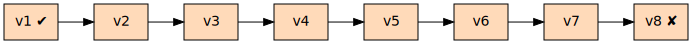

In [10]:
# ignore
display_versions({1: PASS, 8: FAIL})

Somewhere between the old version "v1" ("yesterday") and the current version "v8" ("today"), the software stopped working. But when exactly? And which change was it that caused the failure?

You may think that this is an easy task: We simply manually test one version after another, thus determining the exact version that first failed. However, 

* this can take a long time (notably in the presence of dozens or even hundreds of versions);
* this may still leave you with _dozens of changes_ applied from one version to another; and
* this is actually a task that can be _fully automated_.

And these "automated" debugging techniques are what we explore in this chapter.

## An Example Version History

As our ongoing example, we start with creating a little version history, using the git version management system. We follow the evolution of the `remove_html_markup()` versions from [the introduction to debugging](Intro_Debugging.ipynb) and [the chapter on assertions](Assertions.ipynb).

### Create a Working Directory

We start with creating a working folder (aptly named `my_project`) in which we will do our work. (Note: should you have a folder of that name, it will be deleted and re-initialized).

In [11]:
PROJECT = 'my_project'

In [12]:
import os
import shutil

In [13]:
try:
    shutil.rmtree(PROJECT)
except FileNotFoundError:
    pass
os.mkdir(PROJECT)

We choose the project folder as our working directory. Any file we create will be created in that folder.

In [14]:
import sys

In [15]:
sys.path.append(os.getcwd())
os.chdir(PROJECT)

### Initialize Git

We set up a local Git repository in our local project folder.

In [16]:
!git init

Initialized empty Git repository in /Users/zeller/Projects/debuggingbook/notebooks/my_project/.git/


In [17]:
!git config user.name "Demo User"

In [18]:
!git config user.email "demo-user@example.com"

In [19]:
!git config advice.detachedHead False

We are now ready to commit our first version. Here's the initial definition of `remove_html_markup()` from [the introduction to debugging](Intro_Debugging.ipynb).

In [20]:
def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

The function `write_source()` takes a function `fun` and writes its source code into a file of the same name – in our case, `remove_html_markup.py`:

In [21]:
import inspect

In [22]:
def write_source(fun: Callable, filename: str = None) -> None:
    if filename is None:
        filename = fun.__name__ + '.py'
    with open(filename, 'w') as fh:
        fh.write(inspect.getsource(fun))

Here is `write_source()` in action:

In [23]:
write_source(remove_html_markup)

In [24]:
print_file('remove_html_markup.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

With `git add` and `git commit`, we add the file to our version repository. The `-m` option defines a _message_ for the commit; this is how we (and potential co-workers) can later retrieve information on what has changed, and why. (The messages we use here are deliberately kept short.)

In [25]:
!git add remove_html_markup.py

In [26]:
!git commit -m "First version"

[master (root-commit) 69c09f0] First version
 1 file changed, 13 insertions(+)
 create mode 100644 remove_html_markup.py


Let us now take the second (buggy) version of `remove_html_markup()` and again write this into our file, thus simulating changing the source code from the first version to the new version:

In [27]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [28]:
write_source(remove_html_markup)

We can inspect the differences between the previously committed version and the current one. Lines prefixed with `+` are added; lines prefixed with `-` are deleted.

In [29]:
!git diff remove_html_markup.py

diff --git a/remove_html_markup.py b/remove_html_markup.py
index 4999dc0..768bae9 100644
--- a/remove_html_markup.py
+++ b/remove_html_markup.py
@@ -1,12 +1,15 @@
 def remove_html_markup(s):  # type: ignore
     tag = False
+    quote = False
     out = ""
 
     for c in s:
-        if c == '<':    # start of markup
+        if c == '<' and not quote:
             tag = True
-        elif c == '>':  # end of markup
+        elif c == '>' and not quote:
             tag = False
+        elif c == '"' or c == "'" and tag:
+            quote = not quote
         elif not tag:
             out = out + c
 


We can now commit this second version, adding it to our repository.

In [30]:
!git commit -m "Second version" remove_html_markup.py

[master 213b202] Second version
 1 file changed, 5 insertions(+), 2 deletions(-)


We create a few more revisions.

### Excursion: Adding More Revisions

We use the additional definitions for `remove_html_markup()` from [the introduction to debugging](Intro_Debugging.ipynb) as additional versions.

These also include "debugging" versions with enabled logging statements, as well as "tentative" versions that may or may not fix the discussed issues. In a real version history, such transient versions would typically not show up – or at least not be made available to co-workers.

In [31]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        print("c =", repr(c), "tag =", tag, "quote =", quote)

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [32]:
write_source(remove_html_markup)

In [33]:
!git commit -m "Third version (with debugging output)" remove_html_markup.py

[master f71c6ec] Third version (with debugging output)
 1 file changed, 2 insertions(+)


In [34]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<':  # and not quote:
            tag = True
        elif c == '>':  # and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [35]:
write_source(remove_html_markup)

In [36]:
!git commit -m "Fourth version (clueless)" remove_html_markup.py

[master 14b5b03] Fourth version (clueless)
 1 file changed, 2 insertions(+), 4 deletions(-)


In [37]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        assert not tag  # <=== Just added

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [38]:
write_source(remove_html_markup)

In [39]:
!git commit -m "Fifth version (with assert)" remove_html_markup.py

[master 0b60788] Fifth version (with assert)
 1 file changed, 4 insertions(+), 2 deletions(-)


In [40]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            assert False  # <=== Just added
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [41]:
write_source(remove_html_markup)

In [42]:
!git commit -m "Sixth version (with another assert)" remove_html_markup.py

[master e8688ea] Sixth version (with another assert)
 1 file changed, 1 insertion(+), 2 deletions(-)


In [43]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif (c == '"' or c == "'") and tag:  # <-- FIX
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [44]:
write_source(remove_html_markup)

In [45]:
!git commit -m "Seventh version (fixed)" remove_html_markup.py

[master c8f9191] Seventh version (fixed)
 1 file changed, 1 insertion(+), 2 deletions(-)


### End of Excursion

Here comes the last version of `remove_html_markup()`, this one from [the chapter on assertions](Assertions.ipynb).

In [46]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

In [47]:
write_source(remove_html_markup)

In [48]:
!git commit -m "Eighth version (with proper assertion)" remove_html_markup.py

[master f4af9c6] Eighth version (with proper assertion)
 1 file changed, 4 insertions(+), 1 deletion(-)


We finally reached the "today" state with the latest version – and find that the latest version has an error. This should come to you as no surprise if you have read the earlier chapters. But if you haven't, you will find that when the argument `s` contains double quotes, these are stripped from the output:

In [49]:
remove_html_markup('"foo"')

'foo'

Consequently, this test assertion fails:

In [50]:
from ExpectError import ExpectError

In [51]:
with ExpectError():
    assert remove_html_markup('"foo"') == '"foo"'

Traceback (most recent call last):
  File "<ipython-input-1-839bf760c807>", line 2, in <module>
    assert remove_html_markup('"foo"') == '"foo"'
AssertionError (expected)


Note that the failure does _not_ occur in the very first version, as introduced above. So the simple question is:

* What is the change that caused the failure?

## Accessing Versions

To find out the failure-inducing change, we first need to be able to access older versions. The command 

```sh
git log
```

gives us a listing of all commits:

In [52]:
!git log

commit f4af9c636de8d47dc6a48359aa8e11bb8670cc12 (HEAD -> master)
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:50 2021 +0200

    Eighth version (with proper assertion)

commit c8f91914c98205b9e0af0318ff5b6abcb09dd5e2
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Seventh version (fixed)

commit e8688ea5f098eaefb89b96cb95affc5c560dd703
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Sixth version (with another assert)

commit 0b607888b79af88fd0a0fddf24d1952b65b8d15a
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Fifth version (with assert)

commit 14b5b039d4ff6c128fd9ff6f91d4bd2cfd629352
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Fourth version (clueless)

commit f71c6ece3719ceb393f6a9505f69d96fc8ef71a7
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Third version (with d

Using the `subprocess` module, we can run `git log` and access its output.

In [53]:
import subprocess

In [54]:
def get_output(command: List[str]) -> str:
    result = subprocess.run(command, 
                            stdout=subprocess.PIPE,
                            universal_newlines=True)
    return result.stdout

The output of `git log` contains the ID of the version (the so-called *commit hash*) as well as the message provided during the commit.

In [55]:
log = get_output(['git', 'log', '--pretty=oneline'])
print(log)

f4af9c636de8d47dc6a48359aa8e11bb8670cc12 Eighth version (with proper assertion)
c8f91914c98205b9e0af0318ff5b6abcb09dd5e2 Seventh version (fixed)
e8688ea5f098eaefb89b96cb95affc5c560dd703 Sixth version (with another assert)
0b607888b79af88fd0a0fddf24d1952b65b8d15a Fifth version (with assert)
14b5b039d4ff6c128fd9ff6f91d4bd2cfd629352 Fourth version (clueless)
f71c6ece3719ceb393f6a9505f69d96fc8ef71a7 Third version (with debugging output)
213b20203a44bdf6093f1e863012bedc1c273e8d Second version
69c09f0ef88ba6947c366b79e566661e0dd9e368 First version



Each hash uniquely identifies a version, and is required to access it. Let us create a list `versions`, where `versions[0]` contains the hash (the id) of the first version, `versions[1]` the second version, and so on.

In [56]:
versions = [line.split()[0] for line in log.split('\n') if line]
versions.reverse()
versions[0]

'69c09f0ef88ba6947c366b79e566661e0dd9e368'

We can now check out the first version:

In [57]:
!git checkout {versions[0]}

HEAD is now at 69c09f0 First version


In [58]:
print_file('remove_html_markup.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

If we read in this definition of `remove_html_markup()` from the first version, we will find that the failure was not yet present:

In [59]:
exec(open('remove_html_markup.py').read())

In [60]:
remove_html_markup('"foo"')

'"foo"'

However, if we check out the _last_ version of that file ...

In [61]:
!git checkout {versions[7]}

Previous HEAD position was 69c09f0 First version
HEAD is now at f4af9c6 Eighth version (with proper assertion)


In [62]:
print_file('remove_html_markup.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    # postcondition
    assert '<' not in out and '>' not in out

    return out

... we find that this is the version that no longer works.

In [63]:
exec(open('remove_html_markup.py').read())

In [64]:
remove_html_markup('"foo"')

'foo'

## Manual Bisecting

As stated above, we could now go and try out one version after another to see with which version the bug was introduced. But again, proceeding in such a _linear_ fashion would be very inefficient. It is much better to proceed by _binary search_: If you know that version $v_n$ passed, and version $v_m$ failed (with $m >n$), then test a version $v' = v_{n + (m - n)/2}$ that is right in the _middle_ between the two.

* If $v'$ passes, then repeat the process with $v'$ and $v_m$.
* If $v'$ fails, then repeat the process with $v_n$ and $v'$.

Such *bisecting* quickly progresses towards the failure-inducing version, as it requires you to take only a logarithmic number of tests. In contrast, progressing linearly through the version history requires a test for each version, which is far more effort.

If you use the git version control system, such bisecting is actually a _built-in feature_, coming to you through the `git bisect` command. Let us illustrate how `git bisect` quickly identifies the version that introduced the error.

A bisecting section with `git` starts with the command `bisect start`.

In [65]:
!git bisect start

Then, you use `git bisect good` to identify the version that worked, and `git bisect bad` to identify the version that was bad – in our case, the hashes of the first and last version.

In [66]:
!git bisect good {versions[0]}

In [67]:
!git bisect bad {versions[7]}

Bisecting: 3 revisions left to test after this (roughly 2 steps)
[14b5b039d4ff6c128fd9ff6f91d4bd2cfd629352] Fourth version (clueless)


We find that `git bisect` automatically has checked out the _middle_ version between the passing and the failing one – in our case, version 4 – and now asks us to assess this version.

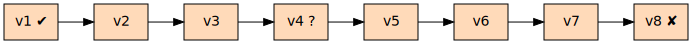

In [68]:
# ignore
display_versions({1: PASS, 4: UNRESOLVED, 8: FAIL})

The version is already in our working folder:

In [69]:
print_file('remove_html_markup.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<':  # and not quote:
            tag = True
        elif c == '>':  # and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

We now need to test this version, and let `git bisect` know the outcome – with

```sh
git bisect good
```

if the test passes, and with

```sh
git bisect bad
```

if the test fails.

It turns out that this version fails:

In [70]:
exec(open('remove_html_markup.py').read())

In [71]:
remove_html_markup('"foo"')

'foo'

So we enter `git bisect bad`:

In [72]:
!git bisect bad

Bisecting: 0 revisions left to test after this (roughly 1 step)
[f71c6ece3719ceb393f6a9505f69d96fc8ef71a7] Third version (with debugging output)


`git bisect` has chosen version 3 to assess – again in the middle between a passing and a failing version:

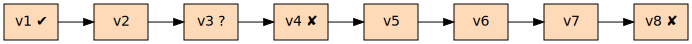

In [73]:
# ignore
display_versions({1: PASS, 3: UNRESOLVED, 4: FAIL, 8: FAIL})

So let us test this version and find that it fails, too:

In [74]:
print_file('remove_html_markup.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        print("c =", repr(c), "tag =", tag, "quote =", quote)

        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [75]:
exec(open('remove_html_markup.py').read())

In [76]:
remove_html_markup('"foo"')

c = '"' tag = False quote = False
c = 'f' tag = False quote = True
c = 'o' tag = False quote = True
c = 'o' tag = False quote = True
c = '"' tag = False quote = True


'foo'

We mark the version as `bad`. `git bisect` then checks out version 2 as the last version to assess.

In [77]:
!git bisect bad

Bisecting: 0 revisions left to test after this (roughly 0 steps)
[213b20203a44bdf6093f1e863012bedc1c273e8d] Second version


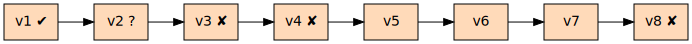

In [78]:
# ignore
display_versions({1: PASS, 2: UNRESOLVED, 3: FAIL, 4: FAIL, 8: FAIL})

When we test version 2, we find that it fails as well:

In [79]:
print_file('remove_html_markup.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [80]:
exec(open('remove_html_markup.py').read())

In [81]:
remove_html_markup('"foo"')

'foo'

Hence, version 2 is _the version that introduced the error_.

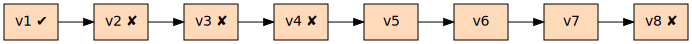

In [82]:
# ignore
display_versions({1: PASS, 2: FAIL, 3: FAIL, 4: FAIL, 8: FAIL})

When we let `git bisect` know that this version fails, it tells us that this version is indeed the "first bad commit":

In [83]:
!git bisect bad

213b20203a44bdf6093f1e863012bedc1c273e8d is the first bad commit
commit 213b20203a44bdf6093f1e863012bedc1c273e8d
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Second version

 remove_html_markup.py | 7 +++++--
 1 file changed, 5 insertions(+), 2 deletions(-)


By comparing this version against the older one, we can see the lines it introduced – namely (buggy) handling of double quotes:

In [84]:
!git diff HEAD^

diff --git a/remove_html_markup.py b/remove_html_markup.py
index 4999dc0..768bae9 100644
--- a/remove_html_markup.py
+++ b/remove_html_markup.py
@@ -1,12 +1,15 @@
 def remove_html_markup(s):  # type: ignore
     tag = False
+    quote = False
     out = ""
 
     for c in s:
-        if c == '<':    # start of markup
+        if c == '<' and not quote:
             tag = True
-        elif c == '>':  # end of markup
+        elif c == '>' and not quote:
             tag = False
+        elif c == '"' or c == "'" and tag:
+            quote = not quote
         elif not tag:
             out = out + c
 


Now that we have identified the failure-inducing change ("something is wrong in `remove_html_markup()`, and it has to do with quote handling"), we can end our `git bisect` session. `git bisect reset` gets us back to the start, such that we can fix the most recent version.

In [85]:
!git bisect reset

Previous HEAD position was 213b202 Second version
HEAD is now at f4af9c6 Eighth version (with proper assertion)


## Automatic Bisecting

Even though manual bisecting can be quick, we can speed things up by writing a _script_ that does the testing for us. With such a script, we can have `git bisect` run fully automatically.

A test script to automate bisecting does the following:

* It (re)builds the program under test for the given version
* It tests whether the failure is present.

Its exit code indicates the test outcome:

* 0 means "good" (the failure did not occur)
* 1 means "bad" (the failure did occur)
* 125 means "undetermined" (we cannot decide if the failure is present or not)

The latter ("undetermined") case may occur if the program fails to build, or shows some other behavior.

We use a Python script `test.py` that reads in `remove_html_markup.py` and then tests for the presence or absence of the failure. (Since this is Python, we don't have to rebuild things.)

In [86]:
# ignore
open('test.py', 'w').write('''
#!/usr/bin/env python

from remove_html_markup import remove_html_markup
import sys

result = remove_html_markup('"foo"')
if result == '"foo"':
    sys.exit(0)  # good/pass
elif result == 'foo':
    sys.exit(1)  # bad/fail
else:
    sys.exit(125)  # unresolved
''');

262

In [87]:
print_file('test.py')

#!/usr/bin/env python

from remove_html_markup import remove_html_markup
import sys

result = remove_html_markup('"foo"')
if result == '"foo"':
    sys.exit(0)  # good/pass
elif result == 'foo':
    sys.exit(1)  # bad/fail
else:
    sys.exit(125)  # unresolved

Right now, we are with version 8 and thus in the "failing" state – our script exits with a code of 1:

In [88]:
!python ./test.py; echo $?

1


Let us use our test script to bisect automatically. As with manual bisecting, we first have to tell `git bisect` which the good (passing) and bad (failing) versions are:

In [89]:
!git bisect start

In [90]:
!git bisect good {versions[0]}

In [91]:
!git bisect bad {versions[7]}

Bisecting: 3 revisions left to test after this (roughly 2 steps)
[14b5b039d4ff6c128fd9ff6f91d4bd2cfd629352] Fourth version (clueless)


Now, we can make use of our script. `git bisect run <script>` automatically determines the failing version. In our case, `<script>` is `python test.py`, and it produces the failing version in less than a second:

In [92]:
!git bisect run python test.py

running python test.py
Bisecting: 0 revisions left to test after this (roughly 1 step)
[f71c6ece3719ceb393f6a9505f69d96fc8ef71a7] Third version (with debugging output)
running python test.py
c = '"' tag = False quote = False
c = 'f' tag = False quote = True
c = 'o' tag = False quote = True
c = 'o' tag = False quote = True
c = '"' tag = False quote = True
Bisecting: 0 revisions left to test after this (roughly 0 steps)
[213b20203a44bdf6093f1e863012bedc1c273e8d] Second version
running python test.py
213b20203a44bdf6093f1e863012bedc1c273e8d is the first bad commit
commit 213b20203a44bdf6093f1e863012bedc1c273e8d
Author: Demo User <demo-user@example.com>
Date:   Tue May 11 15:25:49 2021 +0200

    Second version

 remove_html_markup.py | 7 +++++--
 1 file changed, 5 insertions(+), 2 deletions(-)
bisect run success


Again, we are at version 2, and can investigate the failure-inducing change:

In [93]:
!git diff HEAD^

diff --git a/remove_html_markup.py b/remove_html_markup.py
index 4999dc0..768bae9 100644
--- a/remove_html_markup.py
+++ b/remove_html_markup.py
@@ -1,12 +1,15 @@
 def remove_html_markup(s):  # type: ignore
     tag = False
+    quote = False
     out = ""
 
     for c in s:
-        if c == '<':    # start of markup
+        if c == '<' and not quote:
             tag = True
-        elif c == '>':  # end of markup
+        elif c == '>' and not quote:
             tag = False
+        elif c == '"' or c == "'" and tag:
+            quote = not quote
         elif not tag:
             out = out + c
 


With `git bisect run` as well, we have to end our bisecting session:

In [94]:
!git bisect reset

Previous HEAD position was 213b202 Second version
HEAD is now at f4af9c6 Eighth version (with proper assertion)


## Computing and Applying Patches

Even if a version control system allows us to identify the change that introduced the failure, a single change between versions can still affect multiple locations. The change between version 1 and version 2 of `remove_html_markup()`, above, for instance, affects four separate locations in a single function. In the real world, changes between versions may affect dozens or even hundreds of locations. The question is:

* Can we break down changes further down to individual locations?

The answer is yes! But for this, we first need a means to break down changes into smaller parts. These parts are called _patches_ – differences in individual code locations that can be determined and applied individually.

To illustrate how to compute and apply patches, let us have an example. We access the source code of the first and second version of `remove_html_markup()`, respectively:

In [95]:
version_1 = get_output(['git', 'show',
                        f'{versions[0]}:remove_html_markup.py'])

In [96]:
print_content(version_1, '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

In [97]:
version_2 = get_output(['git', 'show',
                        f'{versions[1]}:remove_html_markup.py'])

In [98]:
print_content(version_2, '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

Patches are what a tool like `diff` produces when comparing two files (or `git diff` when comparing two versions). Here, we see that the difference between the two files consists of four patches, each one affecting a different line in the program.

In [99]:
!git diff {versions[0]} {versions[1]}

diff --git a/remove_html_markup.py b/remove_html_markup.py
index 4999dc0..768bae9 100644
--- a/remove_html_markup.py
+++ b/remove_html_markup.py
@@ -1,12 +1,15 @@
 def remove_html_markup(s):  # type: ignore
     tag = False
+    quote = False
     out = ""
 
     for c in s:
-        if c == '<':    # start of markup
+        if c == '<' and not quote:
             tag = True
-        elif c == '>':  # end of markup
+        elif c == '>' and not quote:
             tag = False
+        elif c == '"' or c == "'" and tag:
+            quote = not quote
         elif not tag:
             out = out + c
 


We'd like to compute and apply such patches without the help of an external program. To this end, we use Google's [diff-match-patch library](https://github.com/google/diff-match-patch).

In [100]:
from diff_match_patch import diff_match_patch, patch_obj

By default, the diff-match-patch library is set up for comparing character strings, not lines; so we have to use a special workaround. Our `diff()` function computes a set of line patches between the two texts `s1` and `s2`:

In [101]:
def diff(s1: str, s2: str, mode: str = 'lines') -> List[patch_obj]:
    """Compare s1 and s2 like `diff`; return a list of patches"""
    dmp = diff_match_patch()
    if mode == 'lines':
        (text1, text2, linearray) = dmp.diff_linesToChars(s1, s2)
        diffs = dmp.diff_main(text1, text2)
        dmp.diff_charsToLines(diffs, linearray)
        return dmp.patch_make(diffs)

    if mode == 'chars':
        diffs = dmp.diff_main(s1, s2)
        return dmp.patch_make(s1, diffs)

    raise ValueError("mode must be 'lines' or 'chars'")

We can use our `diff()` function to compare the two versions of `remove_html_markup()`. We obtain four `patch_obj` patch objects:

In [102]:
patches = diff(version_1, version_2)
patches

To inspect these patches, one can simply `print()` them; however, their string representation uses URL encoding for special characters. We introduce a `patch_string()` function that decodes them again, and then print out the four patches:

In [103]:
import urllib

In [104]:
def patch_string(p: patch_obj) -> str:
    return urllib.parse.unquote(str(p).strip())  # type: ignore

In [105]:
def print_patch(p: patch_obj) -> None:
    print_content(patch_string(p), '.py')
    print()

In [106]:
for p in patches:
    print_patch(p)

@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""
@@ -104,50 +104,43 @@
  s:

-        if c == '<':    # start of markup

+        if c == '<' and not quote:
@@ -162,48 +162,45 @@
 rue

-        elif c == '>':  # end of markup

+        elif c == '>' and not quote:
@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif


Each patch comes with a _location_ (the part between `@@` characters as a character offset into the string) and a _change_ (prefixed by `+` for added lines or `-` for deleted lines) in a particular _context_ (notably, the preceding and following line).

This _context_ allows us to _apply_ patches even if the location no longer exactly matches – the last patch, for instance, introducing `elif c == '"'...`, for instance, is applied between the lines `tag = False` and the next `elif`.

We define a `patch()` function that applies a list of patches to a string, again wrapping around the function provided by the diff-match-patch library.

In [107]:
def patch(text: str, patches: List[patch_obj]) -> str:
    """Apply given patches on given text; return patched text."""
    dmp = diff_match_patch()
    patched_text, success = dmp.patch_apply(patches, text)
    assert all(success), "Could not apply some patch(es)"
    return patched_text

Here's how to use `patch()`. First, if we apply _all_ patches between version 1 and version 2 on version 1, we get version 2:

In [108]:
print_content(patch(version_1, patches), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [109]:
assert patch(version_1, patches) == version_2

Applying _no_ patch leaves the content unchanged.

In [110]:
assert patch(version_1, []) == version_1

However, one can also apply _partial_ sets of patches. For instance, if we only apply the first patch...

In [111]:
print(patch_string(patches[0]))

@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""


... we find that the result includes the added line `quote = False`, but nothing else:

In [112]:
print_content(patch(version_1, [patches[0]]), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

Likewise, we can also apply the second patch individually:

In [113]:
print_content(patch(version_1, [patches[1]]), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

In [114]:
quiz("What has changed in version 1 after applying the second patch?",
     [
         "The initialization of quote is deleted",
         "The condition after `if c == '<'` is expanded",
         "The tag variable gets a different value",
         "None of the above"
     ], '1 / 1 + 1 ** 1 - 1 % 1 * 1')

## Delta Debugging on Patches

With the ability to apply arbitrary sets of patches, we can now go and apply [Delta Debugging](DeltaDebugger.ipynb) to identify failure-inducing patches. The idea is simple: If applying _no_ patch makes the test pass, and applying _all_ patches makes the test fail, then we can use Delta Debugging to identify a minimal set of failure-inducing patches.

Let us write a testing function that checks for the presence of the failure. `test_remove_html_markup_patches()` 

* takes a list of patches,
* applies them on version 1, 
* reads in the definition of `remove_html_markup()`
* and then invokes it to check if the error is present.

In [115]:
def test_remove_html_markup_patches(patches: patch_obj) -> None:
    new_version = patch(version_1, patches)
    exec(new_version, globals())
    assert remove_html_markup('"foo"') == '"foo"'

If no patches are applied, we are at version 1, and the error is not present.

In [116]:
test_remove_html_markup_patches([])

If _all_ patches are applied, we are at version 2, and the error _is_ present.

In [117]:
with ExpectError(AssertionError):
    test_remove_html_markup_patches(patches)

Traceback (most recent call last):
  File "<ipython-input-1-899e4aa0f13c>", line 2, in <module>
    test_remove_html_markup_patches(patches)
  File "<ipython-input-1-51c2474cb795>", line 4, in test_remove_html_markup_patches
    assert remove_html_markup('"foo"') == '"foo"'
AssertionError (expected)


### A Minimal Set of Patches

We can now apply delta debugging on the list of patches, simply by invoking a `DeltaDebugger`:

In [118]:
from DeltaDebugger import DeltaDebugger

In [119]:
with DeltaDebugger() as dd:
    test_remove_html_markup_patches(patches)

These is the minimal set of failure-inducing patches:

In [120]:
reduced_patches = dd.min_args()['patches']

In [121]:
for p in reduced_patches:
    print_patch(p)

@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""
@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif


This is the resulting code. We see that the changes to the conditions (`if c == '<'` and `if c == '>'`) are not necessary to produce the failure – our test string has no HTML tags.

In [122]:
print_content(patch(version_1, reduced_patches), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

Hence, we have now narrowed down our failure-inducing changes from four patches down to two.

### A Minimal Difference

Can we narrow this down even further? Yes, we can! The idea is to not only search for the minimal set of patches to be applied on the passing version, but to actually seek a minimal _difference_ between two patch sets. That is, we obtain 

* one set of _passing_ patches that, when applied, still passes;
* one set of _failing_ patches that, when applied, fails;

with a _minimal difference_ between the two. This minimal difference is what causes the failure.

We obtain such two sets (as well as their difference) by using the `min_arg_diff()` method of the `DeltaDebugger`.

In [123]:
pass_patches, fail_patches, diffs = \
    tuple(arg['patches'] for arg in dd.min_arg_diff())

This is `remove_html_markup[)` with the passing set applied. We see that the variable `quote` is defined at the beginning. This definition is actually a precondition for other patches to result in an executable program; otherwise, the program will fail when the variable `quote` does not exist.

In [124]:
print_content(patch(version_1, pass_patches), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

Here's `remove_html_markup()` with the failing set applied. We see that now we also have the check for double quotes:

In [125]:
print_content(patch(version_1, fail_patches), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

The difference is just this one patch:

In [126]:
for p in diffs:
    print_patch(p)

@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif


And one more time, we are pointed to the buggy line that introduced the error.

## A ChangeDebugger class

Let us put all these steps together in a single class. The `ChangeDebugger` is a derivative of `CallCollector` which takes two source files (one passing, one failing).

In [127]:
from DeltaDebugger import CallCollector

In [128]:
class ChangeDebugger(CallCollector):
    def __init__(self, pass_source: str, fail_source: str, **ddargs: Any) -> None:
        """Constructor. Takes a passing source file (`pass_source`)
        and a failing source file (`fail_source`).
        Additional arguments are passed to `DeltaDebugger` constructor.
        """
        super().__init__()
        self._pass_source = pass_source
        self._fail_source = fail_source
        self._patches = diff(pass_source, fail_source)
        self._ddargs = ddargs
        self.log = ddargs['log'] if 'log' in ddargs else False

    def pass_source(self) -> str:
        """Return the passing source file."""
        return self._pass_source

    def fail_source(self) -> str:
        """Return the failing source file."""
        return self._fail_source

    def patches(self) -> List[patch_obj]:
        """Return the diff between passing and failing source files."""
        return self._patches

From `CallCollector`, it inherits the ability to inspect a single function call...

In [129]:
def test_remove_html_markup() -> None:
    assert remove_html_markup('"foo"') == '"foo"'

In [130]:
with ChangeDebugger(version_1, version_2) as cd:
    test_remove_html_markup()

... and to repeat it at will.

In [131]:
with ExpectError(AssertionError):
    cd.call()

Traceback (most recent call last):
  File "<ipython-input-1-1cdc3d223902>", line 2, in <module>
    cd.call()
  File "/Users/zeller/Projects/debuggingbook/notebooks/DeltaDebugger.ipynb", line 206, in call
    return self.function()(**args)
  File "<ipython-input-1-6809e80c588d>", line 2, in test_remove_html_markup
    assert remove_html_markup('"foo"') == '"foo"'
AssertionError (expected)


We can access the passing source, the failing source, and the list of patches:

In [132]:
print_content(cd.pass_source(), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

In [133]:
print_content(cd.fail_source(), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [134]:
cd.patches()

For testing, we do not apply Delta Debugging on the function under test – that would reduce the function's arguments. (It would still be neat, but that's not what we're aiming for here.)

Instead, we introduce a method `test_patches()` that gets a set of patches, applies them, reads in the resulting source, and (re-)calls the function.

In [135]:
class ChangeDebugger(ChangeDebugger):
    def test_patches(self, patches: List[patch_obj]) -> None:
        new_version = patch(self.pass_source(), patches)
        exec(new_version, globals())
        self.call()

For completeness, we ensure that at the beginning of the `with` block, we assume the failing source:

In [136]:
class ChangeDebugger(ChangeDebugger):
    def __enter__(self) -> Any:
        """Called at begin of a `with` block. Checks if current source fails."""
        exec(self.fail_source(), globals())
        return super().__enter__()

Here's `test_patches()` in action. As before, if we apply no patches, the test passes; if we apply all patches, it fails.

In [137]:
with ChangeDebugger(version_1, version_2) as cd:
    test_remove_html_markup()

In [138]:
cd.test_patches([])

In [139]:
with ExpectError(AssertionError):
    cd.test_patches(cd.patches())

Traceback (most recent call last):
  File "<ipython-input-1-27b59634b5f9>", line 2, in <module>
    cd.test_patches(cd.patches())
  File "<ipython-input-1-cdf9e7513b95>", line 5, in test_patches
    self.call()
  File "/Users/zeller/Projects/debuggingbook/notebooks/DeltaDebugger.ipynb", line 206, in call
    return self.function()(**args)
  File "<ipython-input-1-6809e80c588d>", line 2, in test_remove_html_markup
    assert remove_html_markup('"foo"') == '"foo"'
AssertionError (expected)


Now for the actual debugging. We introduce a method `min_patches()` in which we invoke a `DeltaDebugger` on the `test_patches()` method we just defined. Using `min_arg.diff()`, it then computes a minimal failure-inducing difference between the patches. 

In [140]:
class ChangeDebugger(ChangeDebugger):
    def min_patches(self) -> Tuple[List[patch_obj], List[patch_obj], List[patch_obj]]:
        """
        Compute a minimal set of patches.
        Returns a triple (`pass_patches`, `fail_patches`, `diff_patches`) 
        where `diff_patches` is the minimal difference between 
        the set `pass_patches` (which, when applied, make the test pass) and 
        the set `fail_patches` (which, when applied, make the test fail).
        """
        patches = self.patches()
        with DeltaDebugger(**self._ddargs) as dd:
            self.test_patches(patches)

        args = dd.min_arg_diff()
        pass_patches = args[0]['patches']
        fail_patches = args[1]['patches']
        diff_patches = args[2]['patches']

        return (pass_patches, fail_patches, diff_patches)

The `__repr__()` method, turning a `ChangeDebugger` into a readable string, computes `min_patches()` and returns a user-readable representation of the patches:

In [141]:
class ChangeDebugger(ChangeDebugger):
    def __repr__(self) -> str:
        """Return readable list of minimal patches"""
        pass_patches, fail_patches, diff_patches = self.min_patches()
        return "".join(patch_string(p) for p in diff_patches)

Here's how to use these methods. First, we invoke `ChangeDebugger` with the given old and new source code versions on our test function.

In [142]:
with ChangeDebugger(version_1, version_2) as cd:
    test_remove_html_markup()

These are the patches we determined:

In [143]:
cd.patches()

We invoke `min_patches` to obtain a minimal set of patches:

In [144]:
pass_patches, fail_patches, diffs = cd.min_patches()
diffs

We can inspect the failure-inducing patches right away:

In [145]:
print(patch_string(diffs[0]))

@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif


Or – even simpler – we can simply print out the `ChangeDebugger` to obtain a readable representation.

In [146]:
cd

@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif

Success!

Does this also work for longer change histories? Let's take the very first and the very last version.

In [147]:
version_8 = get_output(['git', 'show', 
                            f'{versions[7]}:remove_html_markup.py'])

In [148]:
with ChangeDebugger(version_1, version_8) as cd:
    test_remove_html_markup()

We start with 5 patches:

In [149]:
len(cd.patches())

5

Printing out the debugger again reveals a single failure-inducing change – it's actually still the same.

In [150]:
cd

@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif

We close with a bit of housekeeping, ensuring that the preconditions are properly met.

In [151]:
from DeltaDebugger import NoCallError, NotFailingError

In [152]:
class NotPassingError(ValueError):
    pass

In [153]:
class ChangeDebugger(ChangeDebugger):
    def after_collection(self) -> None:
        """Diagnostics."""
        if self.function() is None:
            raise NoCallError("No function call observed")
        if self.exception() is None:
            raise NotFailingError(f"{self.format_call()} did not raise an exception")

        try:
            self.test_patches([])
        except Exception:
            raise NotPassingError(f"{self.format_call()} raised an exception in its passing version")

        try:
            self.test_patches(self.patches())
            raise NotFailingError(f"{self.format_call()} did not raise an exception in failing version")
        except Exception:
            pass

        if self.log:
            print(f"Observed {self.format_call()}" +
                  f" raising {self.format_exception(self.exception())}")  

In [154]:
with ExpectError(NotPassingError):
    with ChangeDebugger(version_1, version_2) as cd:
        test_remove_html_markup()

With this, we're done. Enjoy debugging changes!

## Synopsis

This chapter introduces a class `ChangeDebugger` that automatically determines failure-inducing code changes.

### High-Level Interface

You are given two Python source codes `source_pass` and `source_fail`, and a function `test()` that works using the definitions in `source_pass`, but raises an exception using the definitions in `source_fail`. Then, you can use `ChangeDebugger` as follows:

```python
with ChangeDebugger(source_pass, source_fail) as cd:
    test()
cd
```

This will produce the failure-inducing change between `source_pass` and `source_fail`, using [Delta Debugging](DeltaDebugger.ipynb) to determine minimal differences in patches applied.

In [155]:
# ignore
source_pass = version_1
source_fail = version_2

Here is an example. The function `test()` passes (raises no exception) if `remove_html_markup()` is defined as follows:

In [156]:
print_content(source_pass, '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif not tag:
            out = out + c

    return out

In [157]:
def test() -> None:
    assert remove_html_markup('"foo"') == '"foo"'

In [158]:
exec(source_pass)
test()

If `remove_html_markup()` is changed as follows, though, then
`test()` raises an exception and fails:

In [159]:
print_content(source_fail, '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [160]:
exec(source_fail)
with ExpectError(AssertionError):
    test()

Traceback (most recent call last):
  File "<ipython-input-1-234ae8e4c288>", line 3, in <module>
    test()
  File "<ipython-input-1-3586595aba89>", line 2, in test
    assert remove_html_markup('"foo"') == '"foo"'
AssertionError (expected)


We can use `ChangeDebugger` to automatically identify the failure-inducing difference:

In [161]:
with ChangeDebugger(source_pass, source_fail) as cd:
    test()
cd

@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif

The lines prefixed with `+` from are the ones in `source_fail` that cause the failure when added. (They also are the ones that should be fixed.)

### Programmatic Interface

For more details or more automation, use the programmatic interface. The method `min_patches()` returns a triple (`pass_patches`, `fail_patches`, `diffs`) where

* applying `pass_patches` still make the call pass
* applying `fail_patches` causes the call to fail
* `diffs` is the (minimal) difference between the two.

The patches come as list of `patch_obj` objects, as defined by Google's [diff-match-patch library](https://github.com/google/diff-match-patch).

In [162]:
pass_patches, fail_patches, diffs = cd.min_patches()

One can apply all patches in `pass_patches` and still not cause the test to fail:

In [163]:
for p in pass_patches:
    print_patch(p)

@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""
@@ -104,50 +104,43 @@
  s:

-        if c == '<':    # start of markup

+        if c == '<' and not quote:


However, as soon as we also apply the patches in `diffs`, we get the failure. (This is also what is shown when we output a `ChangeDebugger`.)

In [164]:
for p in diffs:
    print_patch(p)

@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif


The full set of methods in `ChangeDebugger` is shown below.

In [165]:
# ignore
from ClassDiagram import display_class_hierarchy

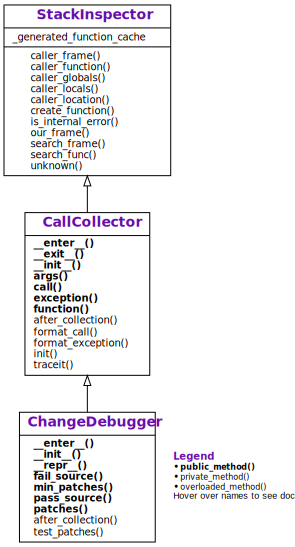

In [166]:
# ignore
display_class_hierarchy([ChangeDebugger],
                        public_methods=[
                            CallCollector.__init__,
                            CallCollector.__enter__,
                            CallCollector.__exit__,
                            CallCollector.call,  # type: ignore
                            CallCollector.args,
                            CallCollector.function,
                            CallCollector.exception,
                            ChangeDebugger.__init__,
                            ChangeDebugger.min_patches,
                            ChangeDebugger.patches,
                            ChangeDebugger.pass_source,
                            ChangeDebugger.fail_source,
                            ChangeDebugger.__repr__,
                            ChangeDebugger.__enter__
                        ],
                        project='debuggingbook')

### Supporting Functions

`ChangeDebugger` relies on lower level `patch()` and `diff()` functions.

To apply patch objects on source code, use the `patch()` function. It takes a source code and a list of patches to be applied.

In [167]:
print_content(patch(source_pass, diffs), '.py')

def remove_html_markup(s):  # type: ignore
    tag = False
    out = ""

    for c in s:
        if c == '<':    # start of markup
            tag = True
        elif c == '>':  # end of markup
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

Conversely, the `diff()` function computes patches between two texts. It returns a list of patch objects that can be applied on text.

In [168]:
for p in diff(source_pass, source_fail):
    print_patch(p)

@@ -48,24 +48,42 @@
 tag = False

+    quote = False

     out = ""
@@ -104,50 +104,43 @@
  s:

-        if c == '<':    # start of markup

+        if c == '<' and not quote:
@@ -162,48 +162,45 @@
 rue

-        elif c == '>':  # end of markup

+        elif c == '>' and not quote:
@@ -215,24 +215,97 @@
 tag = False

+        elif c == '"' or c == "'" and tag:
            quote = not quote

         elif


## Lessons Learned

* If one has a version history available, one can use it to determine failure-inducing changes.
* Bisecting with git effectively isolates failure-inducing commits, both manually and automatically.
* Delta debugging on changes allows to further isolate minimal sets of failure-inducing changes.

## Next Steps

This concludes our applications of Delta Debugging. In the next chapters, we will analyze how to abstract failure-inducing inputs into failure-inducing _input sets_.

## Background

The concept of "bisecting" as traversing a version history to identify failure-inducing changes was first described by Brian Ness and Viet Ngo from Cray Research as "Source change isolation" \cite{Ness1997}. The abstract of their paper summarizes the goals and benefits:

> Effective regression containment is an important factor in the design of development and testing processes for large software projects, especially when many developers are doing concurrent work on a common set of sources. Source change isolation provides an inexpensive, mechanical alternative to analytical methods for identifying the cause of software regressions. It also provides the advantage of enabling regressions to be eliminated by reversing the effect of source changes that introduced errant behavior, without the need to write new code, and without halting other development work on the same software. Deliverability is also improved.

Delta Debugging on changes (and also Delta Debugging) was introduced in "Yesterday, my program worked. Today, it does not. Why?" \cite{Zeller1999}, a paper which would win an ACM SIGSOFT Impact Paper Award ten years later.
This paper generalized over \cite{Ness1997} by identifying failure-inducing differences in arbitrary sets of changes. \cite{Zeller2002} generalized the algorithm to work on inputs and other collections (including changes); the [chapter on delta debugging](DeltaDebugger), which we use in this chapter, uses the \cite{Zeller2002} formulation of the `dd` algorithm.

We're done, so we clean up a bit:

In [169]:
try:
    shutil.rmtree(PROJECT)
except FileNotFoundError:
    pass

## Exercises


### Exercise 1: Fine-Grained Changes

Instead of computing patches on lines (as we and most `diff` programs do), one can also compute fine-grained diffs, using our `diff()` function with `mode='chars'`. Would this make sense?

**Solution.** Let us see what happens if we compute a character `diff` on our two versions:

In [170]:
patches = diff(version_1, version_2, mode='chars')

In [171]:
for p in patches:
    print(patch_string(p))

@@ -52,24 +52,42 @@
 = False
    
+quote = False
    
 out = ""


@@ -123,30 +123,23 @@
  '<'
-:
  
-   # st
 a
-rt
+nd
  
+n
 o
-f
+t
  
-mark
+q
 u
-p
+ote:
 

@@ -183,26 +183,23 @@
  '>'
-:  #
  
-e
+a
 nd 
+n
 o
-f
+t
  
-mark
+q
 u
-p
+ote:
 

@@ -213,24 +213,97 @@
   tag = Fals
+e
        elif c == '"' or c == "'" and tag:
            quote = not quot
 e
        el


We see that the patches now replace words like `start` to `and`, keeping the `a` common to both words. Such tiny differences may be useful for merging changes in text documents (which is what the Google library was built for), but not necessarily code.

### Exercise 2: Failure-Inducing Changes in the Large

Our `ChangeDebugger` class works on two versions of one class, function, or module, but not on versions of an entire project. Extend `ChangeDebugger` to a class `DiffDebugger` that can actually take two _directories_ (including differences in subdirectories with added and deleted files) and determine failure-inducing differences between them. This would allow checking out two versions of a project and determine failure-inducing differences.

Note that applying delte debugging on large sets of differences is a time-consuming task, since 

* Every test requires a rebuild and rerun of the code; and
* There are many ways to cause inconsistencies by applying random changes.

Refer to \cite{Zeller1999} for some hints on how to make this efficient.

### Exercise 3: Hierarchical Change Debugging

Rather than running Delta Debugging on _all_ changes between two projects (as with `DiffDebugger`, above), it can be wise to first progress along the change history (as with `git bisect`) and only then run Delta Debugging on the remaining changes. 

Building on `DiffDebugger`, implement a class `GitDebugger` that takes two version identifiers (= the "good" and "bad" hashes in `git bisect`) and a test (like `ChangeDebugger`) and then

1. runs `git bisect` to narrow down the failure-inducing commit
2. runs `ChangeDebugger` to further narrow down the failure-inducing change within the failure-inducing commit.

This gives you the best of two worlds: The failure-inducing commit is quickly identified; and the additional `ChangeDebugger` run provides even more fine-grained details, albeit at the expense of (potentially several) additional tests.